# Initial attempt at setting up a simple image classification model using embeddings and KNN

In this notebook we built an embedding and train a KNN model on it. 
The coding for the embedding is based on https://github.com/rom1504/image_embeddings. 

In [ ]:
# Install efficientnet which includes a CNN architecture
!pip install efficientnet
#Install pyarrow which includes a python API for access to a Arrow C++ library
!pip install pyarrow

#delete previous results and create a new folder for the results of this run
!rm -rf ../data/embeddings_train
!mkdir ../data/embeddings_train

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

%matplotlib inline

import tensorflow as tf

#import glob
import tqdm # progress bar

import pyarrow.parquet as pq
import pyarrow as pa

from efficientnet.tfkeras import EfficientNetB0

import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
sns.set_style("darkgrid") # darkgrid
sns.set_context("notebook") # paper, notebook, talk, and poster

## Embeddings

Before run the rest of this notebook, load the TFRecord files, that were split into shards and saved in the notebook "Convert_train_image_labels_to_tfrec.ipynb". This is necessary because while trying to do this without shards we quickly ran out of memory.

In [ ]:
#change here to your directory and make sure you have already build the folders 
base_path = '/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/images_train_tfrec/'
embed_path = '/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/'
#select three of the four channels to fulfill RGB requirements - yellow was reported to be the least 
#informative channel 
str_list = ['_red.png', '_blue.png', '_green.png']# ,'_yellow.png']

Following functions contain the functionalities for loading the data, for getting the embeddings, for running inference and for saving it as parquet table files.

In [3]:
def parse_tfrecord_fn(example):
    """
    parse the saved data in the TFRecord file and append 
    name and path of the file

    Parameter
    ---------
    example: dict
        Information saved in a TFRecord file
    Returns
    ---------
    example: dict 
        Information saved in a TFRecord file now with name, path and 
        target_Id for each picture
    """
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        # "area": tf.io.FixedLenFeature([], tf.float32),
        # "bbox": tf.io.VarLenFeature(tf.float32),
        # "category_id": tf.io.FixedLenFeature([], tf.int64),
        # "id": tf.io.FixedLenFeature([], tf.int64),
        "target_id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    #example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example

def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    """
    Save the embeddings in a special data format - Parpquet - which is good for
    handling big data

    Parameter
    ---------
    embeddings: list
        prediction of embedding function 
    dataset: TFRecordDataset
        Dataset for the embedded data
    path: str
        path to a embedded data 
    """
    embeddings = pa.array(embeddings.tolist(), type=pa.list_(pa.float32()))
    target_ids = pa.array(dataset.map(lambda image_raw, target_id, image_path: target_id).as_numpy_iterator())
    image_paths = pa.array(dataset.map(lambda image_raw, target_id, image_path: image_path).as_numpy_iterator())
    table = pa.Table.from_arrays([target_ids, image_paths, embeddings], ["target_id", "image_path", "embedding"])
    # round about way to get image name without path
    df_out = table.to_pandas()
    df_out['image_name'] = df_out['image_path'].str.decode('UTF-8').str.split('/').str[-1].str.split('.').str[0]
    df_out['image_name'] = df_out['image_name'].str.encode('UTF-8')
    # back to parquet format for saving
    table = pa.Table.from_pandas(df_out)
    pq.write_table(table, path)
    
def images_to_embeddings(model, dataset, batch_size):
    """
    Do the actual embedding. 

    Parameter
    ---------
    model: obj
        object of a class for creating an embedding (e.g. a CNN)
    dataset: TFRecordDataset
        with needed information parsed dataset
    batch_size: int
        size of dataset part run at the same time
    Returns
    ---------
    prediction: list
        prediction of the embedded dataset 
    """
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, target_id, image_path: image_raw), verbose=1)

def preprocess_image(d):
    """
    Converts pictures in a format of float32, extract the target Id and the path to the picture.
    
    Parameter
    ---------
    d: TFRecordDataset
        with needed information parsed dataset
    Returns
    ---------
    image_raw: tf.float32
        pictures in a format of float32
    target_id: str
        target ID from the from the original .csv file
    image_path: str
        path to picture
    """   
    target_id = d['target_id']
    raw = d['image']
    image_path = d['path']
    image_raw = tf.image.convert_image_dtype(raw, tf.float32)

    return image_raw, target_id, image_path

def get_dataset(file):
    """
    Get the Dataset in a workable format and parse it with all needed information

    Parameter
    ---------
    file: str
        Filename for a dataset
    Returns
    ---------
    parsed_dataset: TFRecordDataset
        with needed information parsed dataset
    """
    #create the dataset
    dataset = tf.data.TFRecordDataset(file)

    #pass every single feature through our mapping function
    #map structures that are created in functions on dataset
    parsed_dataset = dataset \
        .map(parse_tfrecord_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .apply(tf.data.experimental.ignore_errors())
    return parsed_dataset

def tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size):
    """
    Get files in TFRecord format and embed each of it with all needed information parsed with it.
    Save this in a parquet in given folder.

    Parameter
    ---------
    tfrecords_folder: str
        path to folder with data which should be embedded
    output_folder: str
        path to folder where embedded data shall be saved
    model: obj
    object of a class for creating an embedding (e.g. a CNN)
    batch_size: int
        size of dataset part run at the same time
    """    
    #files = glob.glob(tfr_dir+pattern, recursive=False)
    tfrecords = [f.numpy().decode("utf-8") for f in \
                 tf.data.Dataset.list_files(tfrecords_folder + "train_images*.tfrec", shuffle=False)]
                 
    for shard_id, tfrecord in enumerate(tfrecords):
        parsed_dataset = get_dataset(tfrecord)

        embeddings = images_to_embeddings(model, parsed_dataset, batch_size)
        print("")
        print("Shard " + str(shard_id))
        current_shard_name = "{}{}_{}of{}.parquet".format(output_folder,'train_embeddings', shard_id, len(tfrecords))
        print(current_shard_name)
        save_embeddings_ds_to_parquet(embeddings, parsed_dataset,current_shard_name)
        #                                output_folder + "embedding_part-" + "{:03d}".format(shard_id) + ".parquet")

    
def run_inference(tfrecords_folder, output_folder, batch_size=100):
    """
    Choose model for embedding and run the actual embedding. 

    Parameter
    ---------
    tfrecords_folder: str
        path to folder with data which should be embedded
    output_folder: str
        path to folder where embedded data shall be saved
    batch_size:
        size of dataset part run at the same time
        Default 100
    """    
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_write_embeddings(tfrecords_folder, output_folder, model, batch_size)


In [5]:
#run the embedding by calling the running function 
if not os.path.exists(embed_path):
    # if directory doesn't exist, create and run_inference to create embeddings
    os.mkdir(embed_path)
    run_inference(base_path, embed_path, 10)


2022-06-30 13:17:55.785607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-30 13:17:55.785820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-30 13:17:56.898588: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-30 13:17:57.479492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 34s 327ms/step

Shard 0
/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/train_embeddings_0of32.parquet
100/100 [==============================] - 35s 348ms/step

Shard 1
/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/train_embeddings_1of32.parquet
100/100 [==============================] - 33s 332ms/step

Shard 2
/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/train_embeddings_2of32.parquet
100/100 [==============================] - 34s 342ms/step

Shard 3
/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/train_embeddings_3of32.parquet
100/100 [==============================] - 33s 332ms/step

Shard 4
/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/train_embeddings_4of32.parquet
100/100 [==============================] - 33s 331ms/step

Shard 5
/Users/r

## KNN model

In [7]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

### Prepare a KNN model 

In [6]:
# load parquet files, convert to pandas and get strings as strings
emb = pq.read_table(embed_path).to_pandas()
for col in ['target_id', 'image_path', 'image_name']:
    emb[col] = emb[col].str.decode('utf-8')#.fillna(df[col]) 
emb

,target_id,image_path,embedding,image_name
0,7,../data/train/4b0d7acc-bbb5-11e8-b2ba-ac1f6b64...,"[-0.14782768, -0.19346946, 0.029495712, -0.114...",4b0d7acc-bbb5-11e8-b2ba-ac1f6b6435d0
1,5 0,../data/train/4b0e4648-bbc2-11e8-b2bb-ac1f6b64...,"[-0.11768038, 0.108380914, -0.07158355, -0.051...",4b0e4648-bbc2-11e8-b2bb-ac1f6b6435d0
2,23,../data/train/4b0fe352-bbbf-11e8-b2ba-ac1f6b64...,"[-0.14264518, -0.14894637, 0.015262008, -0.138...",4b0fe352-bbbf-11e8-b2ba-ac1f6b6435d0
3,2,../data/train/4b1164e4-bbaf-11e8-b2ba-ac1f6b64...,"[-0.14977421, -0.12706101, -0.17702478, -0.087...",4b1164e4-bbaf-11e8-b2ba-ac1f6b6435d0
4,25,../data/train/4b120c9e-bbb1-11e8-b2ba-ac1f6b64...,"[-0.15020615, -0.008659467, -0.14262204, -0.04...",4b120c9e-bbb1-11e8-b2ba-ac1f6b6435d0
...,...,...,...,...
31067,7,../data/train/9d04d730-bbb5-11e8-b2ba-ac1f6b64...,"[-0.095827445, -0.14014255, -0.1306586, -0.081...",9d04d730-bbb5-11e8-b2ba-ac1f6b6435d0
31068,4,../data/train/9d09c7e0-bb9c-11e8-b2b9-ac1f6b64...,"[-0.109680824, -0.07402489, -0.08704822, -0.08...",9d09c7e0-bb9c-11e8-b2b9-ac1f6b6435d0
31069,0,../data/train/9d0a7012-bbc6-11e8-b2bc-ac1f6b64...,"[-0.14760047, -0.105946906, 0.17695697, -0.130...",9d0a7012-bbc6-11e8-b2bc-ac1f6b6435d0
31070,25 0,../data/train/9d10ecec-bba0-11e8-b2b9-ac1f6b64...,"[-0.12235144, -0.12698074, -0.052961998, -0.10...",9d10ecec-bba0-11e8-b2b9-ac1f6b6435d0


In [46]:
# get the features in one dataframe
df_feats = pd.DataFrame(list(map(np.ravel, emb.embedding)))
df_feats

In [2]:
# get the targets and one hot encode into a dataframe

# courtesy of https://www.kaggle.com/code/allunia/protein-atlas-exploration-and-baseline
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

# Dictionary is in wrong order to work with it. Turn it around.
reverse_train_labels = dict((v,k) for k,v in label_names.items())

In [ ]:
def fill_targets(row):
    """
    Modify the string with all labels in the target in a hot encoding format  

    Parameter
    ---------
    row: series
        row of the target DataFrame with all labels as a string

    Returns
    ---------
    row: series
        modified row of the target DataFrame in a hot encoding format
    """
    row.target_id = np.array(row.target_id.split(" ")).astype(np.int)
    for num in row.target_id:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

# target dataframe
targets = emb[['target_id', 'image_name']]

# add column for each protein and set to 0
for key in label_names.keys():
    targets[label_names[key]] = 0
# for each target value, set corresponding column = 1
targets = targets.apply(fill_targets, axis=1)

In [43]:
#ID and name of Target is not needed anymore because it is encoded in the other columns
targets.drop(['target_id', 'image_name'],axis=1, inplace=True)
targets.head()

,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [52]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_feats, targets, random_state=1)

### Train the model

In [63]:
# Train model
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
#knn.fit(X_train, y_train)

#use model object to create a object from a Multiclassifier 
multi_target_knn = MultiOutputClassifier(knn)
multi_target_knn.fit(X_train, y_train)#.predict(X)

MultiOutputClassifier(estimator=KNeighborsClassifier(metric='euclidean'))

### Predict data

In [65]:
# Predict on test set
y_pred = multi_target_knn.predict(X_test)
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [71]:
y_pred.shape

(7768, 28)

In [88]:

# Print confusion matrix
#sns.heatmap(multilabel_confusion_matrix(y_test, y_pred), annot=True, cmap='YlGn');
mcm = multilabel_confusion_matrix(y_test, y_pred)

tn = mcm[:, 0, 0]
tp = mcm[:, 1, 1]
fn = mcm[:, 1, 0]
fp = mcm[:, 0, 1]
recall = tp / (tp + fn)
precision = tp/ (fp+tp)
specificity = tn / (tn + fp)
f1 = 2*(precision*recall)/(precision + recall)
accuracy = (tp + tn) / (tp + tn + fn + fp)

df_metrics = pd.DataFrame({'recall': recall, 'precision': precision, 'f1':f1, 'accuracy':accuracy})

# Print accuracy score 
print("Accuracy:", accuracy.round(2))
print("Precision:", precision.round(2))
print("Recall:", recall.round(2))
print("F1:", f1.round(2))
print("-----"*10)

df_metrics


Accuracy: [0.64 0.95 0.88 0.94 0.94 0.92 0.97 0.9  1.   1.   1.   0.96 0.98 0.98
 0.97 1.   0.98 0.99 0.97 0.95 0.99 0.88 0.97 0.9  0.99 0.75 0.99 1.  ]
Precision: [0.59 0.24 0.36 0.25 0.39 0.24 0.36 0.22  nan  nan  nan 0.29 0.3  0.36
 0.75  nan 0.33 0.5  0.44 0.22  nan 0.56 0.38 0.33 0.33 0.51 0.5   nan]
Recall: [0.49 0.03 0.06 0.02 0.05 0.04 0.02 0.04 0.   0.   0.   0.02 0.02 0.06
 0.1  0.   0.01 0.02 0.04 0.02 0.   0.14 0.01 0.06 0.02 0.3  0.03  nan]
F1: [0.53 0.05 0.11 0.04 0.09 0.07 0.04 0.07  nan  nan  nan 0.03 0.03 0.1
 0.17  nan 0.02 0.04 0.07 0.03  nan 0.22 0.03 0.1  0.04 0.38 0.05  nan]
--------------------------------------------------


/var/folders/vn/y7lprnhs06j1j5w4cj9t64080000gn/T/ipykernel_49408/2543887288.py:10: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
/var/folders/vn/y7lprnhs06j1j5w4cj9t64080000gn/T/ipykernel_49408/2543887288.py:11: RuntimeWarning: invalid value encountered in divide
  precision = tp/ (fp+tp)


,recall,precision,f1,accuracy
0,0.491033,0.587495,0.534950,0.644567
1,0.026549,0.243243,0.047872,0.953913
2,0.062159,0.363057,0.106145,0.876416
3,0.024155,0.250000,0.044053,0.944130
4,0.048611,0.388889,0.086420,0.942842
5,0.039539,0.240000,0.067893,0.915165
6,0.021277,0.357143,0.040161,0.969233
7,0.038627,0.223140,0.065854,0.901390
8,0.000000,NaN,NaN,0.997812
9,0.000000,NaN,NaN,0.998069


<AxesSubplot:>

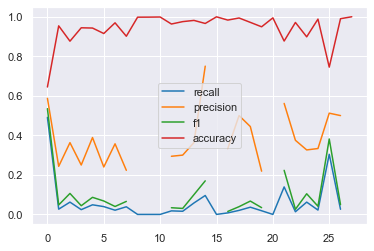

In [89]:
df_metrics.plot()

The model only gives reasonable prediction for the first and the 25th feature. This are the features most often labeled in the pictures. <br>
To get better results for the other features we need to build model extra for that feature. The best two we can go on together in one CNN. 